In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [2]:
# Some constants
cutOffMLTMLATUniqCnt = 4

In [3]:
# Asy Inds
asyDF = pandas.read_csv( "../data/Asy_processed.txt", sep=' ' )
asyDF["date"] = pandas.to_datetime(asyDF["datetimeStr"], format='%Y%m%d-%H-%M')
asyDF["hour"] = asyDF["date"].apply(lambda x: x.strftime('%H'))
asyDF["minute"] = asyDF["date"].apply(lambda x: x.strftime('%M'))
asyDF["dtStr"] = asyDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
asyDF.head()

,datetimeStr,AsyD,AsyH,SymD,SymH,date,hour,minute,dtStr
0,20110101-00-00,17.0,13.0,1.0,-10.0,2011-01-01 00:00:00,00,00,20110101
1,20110101-00-01,17.0,13.0,1.0,-10.0,2011-01-01 00:01:00,00,01,20110101
2,20110101-00-02,17.0,13.0,1.0,-10.0,2011-01-01 00:02:00,00,02,20110101
3,20110101-00-03,17.0,13.0,1.0,-10.0,2011-01-01 00:03:00,00,03,20110101
4,20110101-00-04,17.0,13.0,1.0,-10.0,2011-01-01 00:04:00,00,04,20110101


In [4]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()
# Filter out some values
# When there aren't good number of measurements at lats
# discard those values
cntMLTPntsDF = velsDataDF[ ["dst_bin", "normMLT", "MLAT"] \
                    ].groupby( ["dst_bin", "normMLT"] \
                    )["MLAT"].nunique().reset_index()
cntMLTPntsDF.columns = ["dst_bin", "normMLT", "MLATCntUnq"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["MLATCntUnq"] >=\
                    cutOffMLTMLATUniqCnt ][ ["dst_bin", "normMLT"]\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, cntMLTPntsDF,\
                    on=["dst_bin", "normMLT"], how="inner" )
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [5]:
# Also merge with aymDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, asyDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
velsDataDF = velsDataDF [ ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date_x','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr_x', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH'] ]
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH']

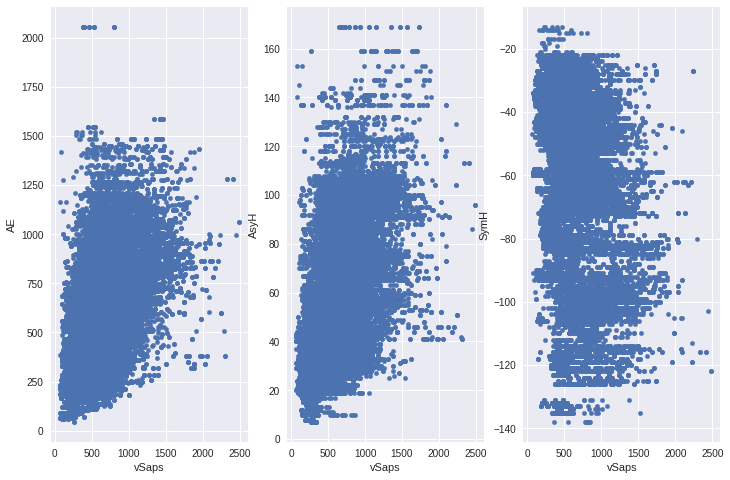

In [21]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,3,1)
ax2 = f.add_subplot(1,3,2)
ax3 = f.add_subplot(1,3,3)

selMltDF = velsDataDF[ velsDataDF["normMLT"] == -5 ][ ["normMLT", "AE", "AsyH", "SymH", "vSaps"] ]
selMltDF.plot( kind="scatter", x="vSaps", y="AE", ax=ax1 )
selMltDF.plot( kind="scatter", x="vSaps", y="AsyH", ax=ax2 )
selMltDF.plot( kind="scatter", x="vSaps", y="SymH", ax=ax3 )